### License

```
Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

# Dynamic World Model Runner

This notebook will step through the process of using the [Earth Engine API](https://developers.google.com/earth-engine) to generate an image of Dynamic World estimated probabilities from a Sentinel-2 L1C image, and then reverse the
probabilities back to reflectance.

This notebook was designed for [Google Colab](https://colab.research.google.com). Make sure to load any model files you intend to use in the Colab file dialog.

## Fetch a Sentinel-2 L1C image

Import the Earth Engine client library.

In [8]:
import ee

Authenticate with Earth Engine first; note this requires an [Earth Engine account](https://signup.earthengine.google.com). If you already have one, make sure to use the same Google account with which you signed up for Earth Engine.

In [9]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code: 4/1AbUR2VPjm12mLsLnr4sfG2vwV7zLQKF7BTPGPh62YIgS3Nm9wxPVIQuF3KM

Successfully saved authorization token.


Sample a Sentinel-2 L1C image into a 3D array (height, width, bands).

In [10]:
# This is Sentinel-2 L1C.
s2 = ee.ImageCollection('COPERNICUS/S2')

# In this example, we'll define a point in the DRC.
POI = ee.Geometry.Point([21.0503961, -3.4844154])

# Filter the collection to mid-October 2021 intersecting the Point Of Interest.
s2 = s2.filterBounds(POI).filterDate('2021-10-05', '2021-10-11')

# Grab the first image in the filtered collection. Dynamic World uses a subset
# of Sentinel-2 bands, so we'll want to select down to just those.
s2_image = s2.first()
s2_image = s2_image.select('B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11',
                           'B12')

# Resample the data so that the bands all map 1 pixel -> 10m. We'll use B2 (red)
# for a reference projection.
s2_image = s2_image.toFloat().resample('bilinear').reproject(
    s2_image.select('B2').projection());

# Squash the image bands down into an array-per-pixel, and sample out a square
# from our image centered on the POI. In this example, we'll go out 2km in each
# direction.
#
# This creates an ee.Feature with a property named "array" that we'll grab
# later.
s2_image_sample = s2_image.toArray().sampleRectangle(POI.buffer(2000))

Import Numpy.

In [11]:
import numpy as np

Get a Numpy array from our 3D array.

In [12]:
image = np.array(s2_image_sample.getInfo()['properties']['array'])

# Note this shape isn't exactly 400 a side (2 * 2km of 10m pixels) since the
# "buffer" we used earlier was in a different (geographic) projection than the
# pixels.
print(image.shape)

(399, 399, 9)


## Normalize the image

In [13]:
original_image = image

# Define per-band constants we'll use to squash the Sentinel-2 reflectance range
# into something on (0, 1). These constants are 30/70 percentiles measured
# across a diverse set of surface conditions after a log transform.

NORM_PERCENTILES = np.array([
    [1.7417268007636313, 2.023298706048351],
    [1.7261204997060209, 2.038905204308012],
    [1.6798346251414997, 2.179592821212937],
    [1.7734969472909623, 2.2890068333026603],
    [2.289154079164943, 2.6171674549378166],
    [2.382939712192371, 2.773418590375327],
    [2.3828939530384052, 2.7578332604178284],
    [2.1952484264967844, 2.789092484314204],
    [1.554812948247501, 2.4140534947492487]])

image = np.log(image * 0.005 + 1)
image = (image - NORM_PERCENTILES[:, 0]) / NORM_PERCENTILES[:, 1]

# Get a sigmoid transfer of the re-scaled reflectance values.
image = np.exp(image * 5 - 1)
image = image / (image + 1)

View the effects of normalization.

In [ ]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(1, 2)
f.set_size_inches(10, 5)

# Note we have to divide down the reflectance in the *original image* to be on 
# [0, 1] to display it with matplotlib; by convention we divide the RGB channels
# by 3000. 
axarr[0].imshow(original_image[:, :, [2, 1, 0]] / 3000)
axarr[0].axes.get_xaxis().set_ticks([])
axarr[0].axes.get_yaxis().set_ticks([])
axarr[0].axes.set_xlabel('Original Image')

axarr[1].imshow(image[:, :, [2, 1, 0]])
axarr[1].axes.get_xaxis().set_ticks([])
axarr[1].axes.get_yaxis().set_ticks([])
axarr[1].axes.set_xlabel('Normalized Image')

plt.show()

## Load the forward model and make predictions

**For this to work properly, make sure you have uploaded the forward model into your Colab session at `/content/forward`.**

Import TensorFlow.

In [16]:
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow'

Load the forward model.

In [ ]:
forward_model = tf.saved_model.load('/content/forward')

Run the model on the normalized Sentinel-2 L1C image.

In [ ]:
# DynamicWorld expects 4D (NHWC), float32 typed inputs.
nhwc_image = tf.expand_dims(tf.cast(image, dtype=tf.float32), axis=0)

# Run the model.
lulc_logits = forward_model(nhwc_image)

# Get the softmax of the output logits.
lulc_prob = tf.nn.softmax(lulc_logits)

# Convert the 4D probabilites back into a 3D numpy array for easier indexing.
lulc_prob = np.array(lulc_prob[0])

Visualize the estimated LULC probabilities.

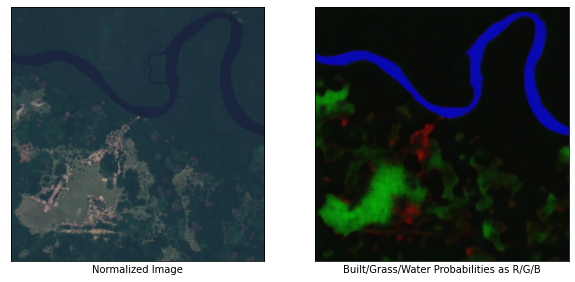

In [ ]:
f, axarr = plt.subplots(1, 2)
f.set_size_inches(10, 5)

axarr[0].imshow(image[:, :, [2, 1, 0]])
axarr[0].axes.get_xaxis().set_ticks([])
axarr[0].axes.get_yaxis().set_ticks([])
axarr[0].axes.set_xlabel('Normalized Image')

# Note 6, 2, and 0 map to DynamicWorld Built, Grass, and Water classes.
axarr[1].imshow(lulc_prob[:, :, [6, 2, 0]])
axarr[1].axes.get_xaxis().set_ticks([])
axarr[1].axes.get_yaxis().set_ticks([])
axarr[1].axes.set_xlabel(
    'Built/Grass/Water Probabilities as R/G/B')

plt.show()

## Load the backward model and synthesize reflectance

**For this to work properly, make sure you have uploaded the backward model into your Colab session at `/content/backward`.**

Load the backward model.

In [ ]:
backward_model = tf.saved_model.load('/content/backward')

Draw a crop circle using PIL.

In [ ]:
#@title
import math
from PIL import Image, ImageDraw

X = 290
Y = 180
R = 35
ANGLE = 280
WIDTH = 8

crop_circle = Image.new('1', (lulc_prob.shape[1], lulc_prob.shape[0]))
canvas = ImageDraw.Draw(crop_circle)

canvas.arc((X - R, Y - R, X + R, Y + R),
           start=ANGLE + 135, end=ANGLE + 45, fill=1, width=WIDTH)
canvas.arc((X - R * 0.6, Y - R * 0.6, X + R * 0.6, Y + R * 0.6),
           start=ANGLE + 315, end=ANGLE + 225, fill=1, width=WIDTH)
canvas.ellipse((X - R * 0.2, Y - R * 0.2, X + R * 0.2, Y + R * 0.2), fill=1)

ANGLE_RADS = ANGLE * math.pi / 180
axis = np.array([math.cos(ANGLE_RADS), math.sin(ANGLE_RADS)])

coords = (X + axis[0] * -R, Y + axis[1] * -R,
          X + axis[0] * R * -1.286, Y + axis[1] * R * -1.286)
canvas.line(coords, fill=1, width=WIDTH)

coords = (X + axis[0] * R, Y + axis[1] * R,
          X + axis[0] * R * 1.286, Y + axis[1] * R * 1.286)
canvas.line(coords, fill=1, width=WIDTH)

SMALL_X, SMALL_Y = X + axis[0] * R * 1.8, Y + axis[1] * R * 1.8
canvas.arc((SMALL_X - R * 0.5, SMALL_Y - R * 0.5,
            SMALL_X + R * 0.5, SMALL_Y + R * 0.5),
           start=ANGLE + 315, end=ANGLE + 225, fill=1, width=WIDTH)
canvas.ellipse((SMALL_X - R * 0.15, SMALL_Y - R * 0.15,
                SMALL_X + R * 0.15, SMALL_Y + R * 0.15), fill=1)

coords = (SMALL_X + axis[0] * R * 0.5, SMALL_Y + axis[1] * R * 0.5,
          SMALL_X + axis[0] * R * 0.8, SMALL_Y + axis[1] * R * 0.8)
canvas.line(coords, fill=1, width=WIDTH)

aug_source = np.array(crop_circle)

Make the generated image modulate the crop probability with some noise.

In [ ]:
#@title
# Add a channel dimension to the augmentation.
augmentation = np.expand_dims(aug_source, axis=-1)
augmentation_mask = augmentation

# Create a one-hot encoded version of the augmentation image, and add some
# noise.
#
# Note channel 4 corresponds to crops.
aug_channels = augmentation * np.array([0, 0, 0, 0, 1, 0, 0, 0, 0],
                                       dtype=np.float32)
aug_channels += np.random.normal(scale=0.02, size=aug_channels.shape)
aug_channels /= np.sum(aug_channels, axis=2, keepdims=True)
aug_channels *= augmentation

Fold the generated image into the forward model's output's.

In [ ]:
lulc_prob_aug = (
    lulc_prob * (1 - augmentation_mask) + aug_channels * augmentation_mask)

Run the backwards model on the augmented probabilities.

In [ ]:
# DynamicWorld expects 4D (NHWC), float32 typed inputs.
nhwc_image = tf.expand_dims(tf.cast(lulc_prob, dtype=tf.float32), axis=0)
nhwc_image_aug = tf.expand_dims(tf.cast(lulc_prob_aug, dtype=tf.float32),
                                axis=0)

# Run the model twice: once for the raw probabilities and once for the raw
# probabilities plus our augmentation.
synthetic_s2 = backward_model(nhwc_image)
synthetic_s2_aug = backward_model(nhwc_image_aug)

# Convert the 4D probabilites back into a 3D numpy array for easier indexing.
synthetic_s2 = np.array(synthetic_s2[0])
synthetic_s2_aug = np.array(synthetic_s2_aug[0])

Visualize the synthesized Sentinel-2 L1C image.

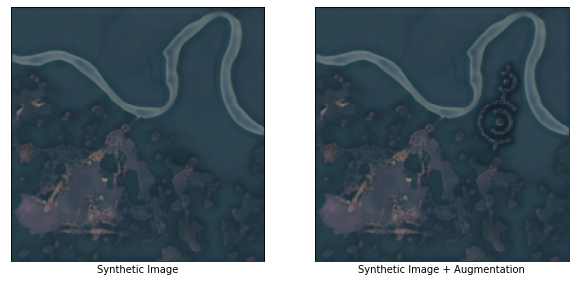

In [ ]:
f, axarr = plt.subplots(1, 2)
f.set_size_inches(10, 5)

axarr[0].imshow(synthetic_s2[:, :, [2, 1, 0]])
axarr[0].axes.get_xaxis().set_ticks([])
axarr[0].axes.get_yaxis().set_ticks([])
axarr[0].axes.set_xlabel('Synthetic Image')

axarr[1].imshow(synthetic_s2_aug[:, :, [2, 1, 0]])
axarr[1].axes.get_xaxis().set_ticks([])
axarr[1].axes.get_yaxis().set_ticks([])
axarr[1].axes.set_xlabel('Synthetic Image + Augmentation')

plt.show()